# Disinformation Signal Detection in Text

This tool analyzes written content (like news articles or social media posts) to detect **manipulative tactics** often used in disinformation. Instead of just labeling text as true or false, it highlights *how* the content may mislead or emotionally influence readers.

---

#### 🔍 What It Detects

The tool scans for over **40 types of signals**, grouped by tactic:

- **Common Signals**: Emotional manipulation, attacks on credibility, black-and-white thinking
- **Conspiracy Theory**: Secret plots, “suppressed truths,” anonymous insiders
- **Trolling**: Provocative insults, memes, hashtag spam
- **Discrediting**: Personal attacks, fake visuals, smear campaigns
- **Pseudoscience & Denialism**: Fake science claims, cherry-picked evidence
- **Polarization**: Us-vs-them language, exaggerated division
- **Hate/Offensive Speech**: Legacy hate and offensive detectors
- **Clickbait**: Misleading headlines

---

#### ⚙️ How It Works

- Built on a **multilingual AI model** that supports 8 EU languages  
- Uses **prompt-based detection** to ask targeted questions about the text  
- Returns a **multi-label output**: a single text can trigger multiple signals  
- Works on both full documents and specific text segments


---

#### 🧩 Why It Matters

This tool helps:
- Understand *how* disinformation is constructed
- Visualize and flag risky content
- Feed results into broader **risk scoring** systems or dashboards


# Detecting Disinformation Tactics in News Articles Over Time

## Overview

This notebook demonstrates how to detect and visualize different disinformation tactics in news articles over a specific period.

## Workflow

* **Data Collection**: Articles with detected disinformation signals are retrieved from the database using a SQL query, then deduplicated by URL to avoid counting duplicates.
* **Aggregation**: Data is grouped by date, counting occurrences of each tactic.
* **Visualization**: Results are presented as a 100% stacked area chart, showing each tactic’s daily proportion over time.

## Interpreting the Results

The stacked area chart illustrates how the prevalence of different disinformation tactics changes each day, allowing easy detection of trends or shifts in strategy. For example, a wider area for "Conspiracy Theory" indicates a relative increase in conspiracy-based misinformation.

## Inputs & Outputs

* **Inputs**: Date range (`START_DATE`, `END_DATE`), top tactics to display (`TOP_N`), and raw disinformation detection data from the news database.
* **Outputs**:

  * JSON file (`news_tool_disinformation_signals_detection_tactic_stacked_area.json`) containing processed data.
  * Stacked area chart showing the share of each disinformation tactic over time.

This notebook provides a clear, visual summary of disinformation trends in news articles, making it easy to track changes and spot emerging patterns.


In [ ]:
# 1 ── Install required packages (Polars, Matplotlib, Trino client)
%pip install -qU "trino[sqlalchemy]==0.332.0" polars matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:

# 2 ── Imports and helper functions
import os, re, json, datetime as dt
from pathlib import Path
from typing import Optional, Tuple

import polars as pl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from trino.dbapi import connect

plt.rcParams["figure.dpi"] = 110  # High-resolution plots for clarity

# ---------- JSON helpers ----------
def _json_default(value):
    if isinstance(value, (dt.datetime, dt.date)):
        return value.isoformat()
    return repr(value)

def save_dict(d: dict, path: Path):
    """Save a dictionary as JSON to the given path (with date handling)."""
    path.write_text(json.dumps(d, default=_json_default))

def load_dict(path: Path) -> dict:
    """Load JSON data from a file into a Python dictionary."""
    return json.loads(path.read_text())

def df_from_data_d(data_d: dict) -> pl.DataFrame:
    """Recreate a Polars DataFrame from stored data, parsing 'date' to date type if present."""
    if "date" in data_d:
        return pl.DataFrame(data_d, schema_overrides={"date": pl.Date})
    return pl.DataFrame(data_d)

# ---------- Host / port parser ----------
def _parse_host_port(host: Optional[str], port: Optional[str], default_port: int = 8080) -> Tuple[str, int]:
    """Parse host and port from strings, with default port and range validation."""
    host = (host or "").strip()
    port = (port or "").strip()
    # Remove any protocol prefix (http:// or tcp://)
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)
    if ":" in host and not port:
        host, port = host.split(":", 1)
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    if not (1 <= port_int <= 65535):
        port_int = default_port
    return host or "localhost", port_int


In [ ]:

# 3 ── Parameters (can be overridden by the caller/notebook)
START_DATE = "2025-03-01"
END_DATE   = "2025-07-25"
TOP_N      = 20

# Trino connection info (environment variables take precedence)
TRINO_HOST, TRINO_PORT = _parse_host_port(os.getenv("TRINO_HOST"), os.getenv("TRINO_PORT"))
TRINO_USER    = os.getenv("TRINO_USER", "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")
# TRINO_SCHEMA can be optionally used if needed (assuming 'news' and 'tools' schemas are accessible)


In [ ]:

# 4 ── Query Trino (deduplicate by earliest created_at per URL, within date range)
parse_created = (
    "COALESCE("
    "  CAST(TRY(from_iso8601_timestamp(cn.created_at)) AS timestamp), "  # ISO 8601 format
    "  TRY(date_parse(cn.created_at, '%Y-%m-%d %H:%i:%s'))"              # Space-separated format
    ")"
)
where_clauses = [
    "(cn.publish_date IS NOT NULL OR cn.created_at IS NOT NULL)"
]
if START_DATE:
    where_clauses.append(
        f"""COALESCE(
                date(from_iso8601_timestamp(cn.publish_date)),
                date({parse_created})
            ) >= DATE '{START_DATE}'"""
    )
if END_DATE:
    where_clauses.append(
        f"""COALESCE(
                date(from_iso8601_timestamp(cn.publish_date)),
                date({parse_created})
            ) <= DATE '{END_DATE}'"""
    )
cn_where_clause = " AND ".join(where_clauses)

sql = f"""
WITH staged AS (
    SELECT
        cn.id,
        cn.url,
        cn.publish_date,
        cn.created_at,
        cn.language,
        cn.topic,
        cn.sourcecountry,
        {parse_created} AS created_ts
    FROM news.collected_news AS cn
    WHERE {cn_where_clause}
),
dedup AS (
    SELECT *,
           ROW_NUMBER() OVER (
               PARTITION BY url
               ORDER BY created_ts
           ) AS rn
    FROM staged
)
SELECT
    COALESCE(
        date(from_iso8601_timestamp(publish_date)),
        date(created_ts)
    ) AS date,
    seg.tactic AS tactic,
    un.language AS language,
    un.topic   AS topic,
    un.sourcecountry AS sourcecountry
FROM dedup AS un
JOIN tools.text_disinformation_signals_detection AS tdsd
     ON un.id = tdsd.content_id
CROSS JOIN UNNEST(tdsd.segment) AS seg (spans, level, name, tactic)
CROSS JOIN UNNEST(seg.spans)    AS sp (segment, confidence, start_pos, end_pos, span_value)
WHERE rn = 1
"""

# Connect to Trino and execute the query
conn = connect(host=TRINO_HOST, port=TRINO_PORT, user=TRINO_USER, catalog=TRINO_CATALOG)
cur = conn.cursor()
try:
    cur.execute(sql)
    rows = cur.fetchall()
    columns = [c[0] for c in cur.description]  # e.g., ["date", "tactic", "language", "topic", "sourcecountry"]
finally:
    cur.close()
    conn.close()


In [ ]:

# 5 ── Build Polars DataFrame & Generate JSON file for visualization
df_all = pl.DataFrame(rows, schema=columns, orient="row")
df_all = df_all.with_columns(pl.col("date").cast(pl.Date))         # ensure Date type
df_all = df_all.filter(pl.col("date") >= dt.date(2025, 1, 1))      # drop pre‑2025
df_all = df_all.sort("date")                                       # sort chronologically

# Determine top tactics and set up color mapping (group others as "Other")
counts_df = (
    df_all
    .group_by("tactic")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)
tactics_all = counts_df["tactic"].to_list()
top_tactics = tactics_all[:TOP_N]
if len(tactics_all) > TOP_N:
    top_tactics.append("Other")

palette = list(plt.get_cmap("tab20").colors)
color_map_hex = {t: mcolors.to_hex(palette[i % len(palette)]) for i, t in enumerate(top_tactics)}
if "Other" in top_tactics:
    color_map_hex["Other"] = "#808080"

# Daily 100% stacked-area data
daily_counts_df = df_all.group_by(["date", "tactic"]).agg(pl.len().alias("count"))
pivot_all = (
    daily_counts_df
    .pivot(index="date", on="tactic", values="count", aggregate_function="sum")
    .fill_null(0)
    .sort("date")
)
if len(tactics_all) > TOP_N:
    # Sum all non-top tactics into an "Other" column
    non_top_cols = [c for c in pivot_all.columns if c not in top_tactics and c != "date"]
    if non_top_cols:
        pivot_all = pivot_all.with_columns(pl.sum_horizontal(*non_top_cols).alias("Other")).drop(non_top_cols)
# Ensure all top tactics (including "Other") are present as columns
for t in top_tactics:
    if t not in pivot_all.columns:
        pivot_all = pivot_all.with_columns(pl.lit(0).alias(t))
df_daily_wide = pivot_all.select(["date"] + top_tactics)
# Calculate daily proportions for each tactic
df_daily_prop = (
    df_daily_wide
    .with_columns(pl.sum_horizontal(*top_tactics).alias("total"))
    .with_columns([(pl.col(t) / pl.col("total")).alias(t) for t in top_tactics])
    .drop("total")
)

stacked_area_data = {
    "data"      : df_daily_prop.to_dict(as_series=False),
    "title"     : "Daily 100% Stacked Area – share of top tactics over time",
    "tactics"   : top_tactics,
    "color_map" : color_map_hex,
    "chart_type": "stacked_area",
    "platform"  : "News"
}
stacked_area_path = Path("news_tool_disinformation_signals_detection_tactic_stacked_area.json")
save_dict(stacked_area_data, stacked_area_path)


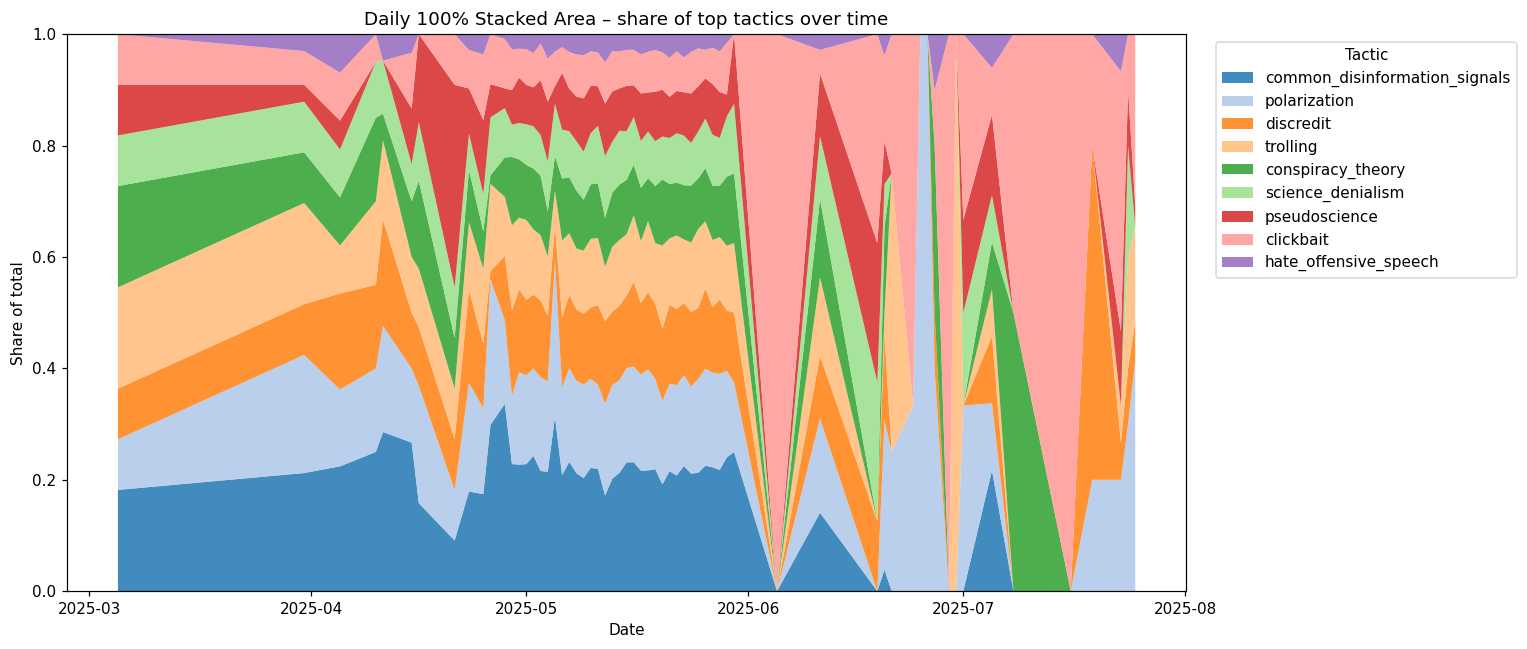

In [ ]:

# 6 ── Load Tactic Stacked Area JSON and Plot
stacked_meta = load_dict(stacked_area_path)
df_stacked = df_from_data_d(stacked_meta["data"])
df_stacked_pd = df_stacked.to_pandas().sort_values("date")
x_dates = df_stacked_pd["date"].tolist()
# Prepare data series in the order of top_tactics for stacking
y_series = [df_stacked_pd[t].tolist() for t in top_tactics]
colors_series = [stacked_meta["color_map"][t] for t in top_tactics]
plt.figure(figsize=(14, 6))
plt.stackplot(x_dates, *y_series, labels=top_tactics, colors=colors_series, alpha=0.85)
plt.title(stacked_meta["title"])
plt.xlabel("Date")
plt.ylabel("Share of total")
plt.ylim(0, 1)
plt.legend(title="Tactic", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()
